In [3]:
%load_ext autoreload
%autoreload 2

import os 
# Set the environment for R
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'


import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from analysis import opponent_visibility
import pickle
import populate_dataframes
from pymer4.models import Lmer



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1] "R version 4.3.3 (2024-02-29)"



### load data

In [4]:
import pickle

analysis_dir = os.path.join('..', 'data')
# analysis_file = 'analysis_results_2levelsFirstSeenWall_normalisedWallSep.pkl'
analysis_file = 'analysis_results_3levelsFirstSeenWall_normalisedWallSep.pkl'
filename = os.path.join(analysis_dir, analysis_file)
# load the analysis results
with open(filename, 'rb') as f:
    analysis_results = pickle.load(f)

### populate dataframes for glm input

In [5]:
# populate dataframes for solo, solosocial, and social analysis_type
glm_df_solo = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solo')
glm_df_solosocial = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solosocial')
glm_df_social = populate_dataframes.populate_dataframe(analysis_results, analysis_type='social')


## Solos

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 5544	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -1750.898 	 AIC: 3509.797

Random effects:

                    Name    Var   Std
GlmPlayerID  (Intercept)  1.188  1.09

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)     1.111   0.704    1.517  0.207   3.036      2.023       4.558  0.752        0.669         0.820   5.358  0.000  ***
D2H             0.170  -0.304    0.645  0.242   1.186      0.738       1.906  0.542        0.424         0.656   0.703  0.482     
D2L             2.393   1.921    2.864  0.241  10.942      6.829      17.531  0.916        0.872         0.946   9.948  0.000  ***


/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Text(0.5, 1.0, 'Solo: ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)')

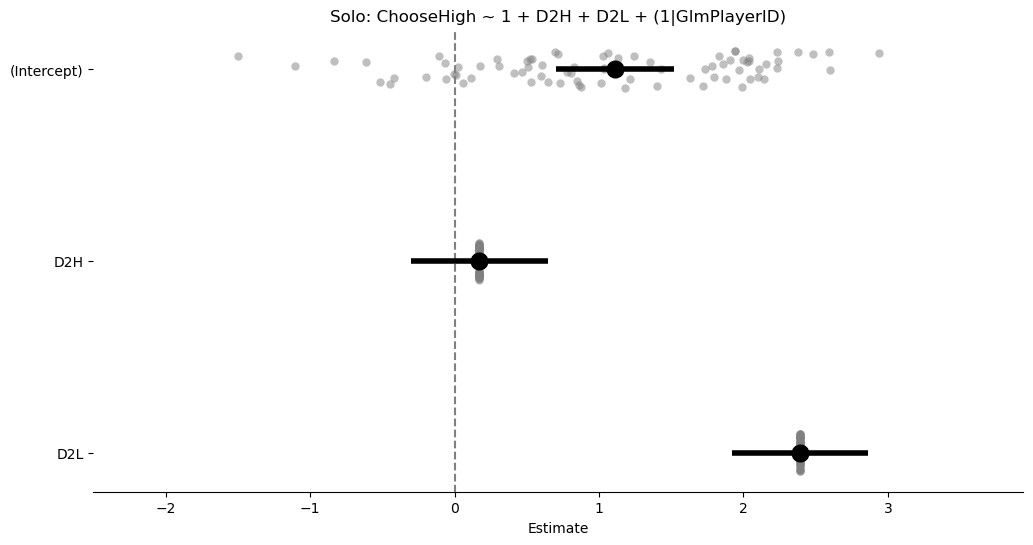

In [11]:
# define model formula
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall + (1|GlmPlayerID)'


# fit the model
model = Lmer(model_formula, data=glm_df_solo, family='binomial')
results=model.fit(
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)

# display model results
print(results)
ax = model.plot_summary()
ax.set_title("Solo: " + model_formula)

### run predictions of the model on all training data

In [13]:
predictions = model.predict(glm_df_solo, verify_predictions=False)

In [16]:
predictions = np.array(predictions)

In [57]:
predictions[1550:1600]

array([0.94612004, 0.95840629, 0.95157989, 0.94796447, 0.95245331,
       0.94764432, 0.95220112, 0.95310807, 0.95550524, 0.94693018,
       0.9545036 , 0.94245052, 0.94925697, 0.95767635, 0.95668206,
       0.95282825, 0.94700938, 0.95437655, 0.95173522, 0.8813911 ,
       0.93702495, 0.9447552 , 0.78745606, 0.88106569, 0.94763346,
       0.92485366, 0.93300382, 0.95088708, 0.94475531, 0.76250308,
       0.8835001 , 0.94478574, 0.94475532, 0.95084317, 0.88106832,
       0.93299833, 0.76240288, 0.68442575, 0.69092824, 0.69724302,
       0.9029883 , 0.8225496 , 0.70611634, 0.94838432, 0.95414751,
       0.83580134, 0.917486  , 0.82689205, 0.94684571, 0.9158148 ])

In [31]:
groundtruth_D2H = glm_df_solo['D2H'].values
groundtruth_D2L = glm_df_solo['D2L'].values
groundtruth_choice = glm_df_solo['ChooseHigh'].values

In [36]:
binned_D2H[:50], binned_D2L[:50]

(array([1, 3, 4, 4, 1, 3, 3, 4, 2, 4, 4, 2, 3, 3, 3, 3, 2, 0, 2, 4, 4, 2,
        2, 2, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 3, 3, 3, 2, 1,
        2, 1, 3, 2, 2, 2]),
 array([1, 2, 3, 4, 2, 4, 2, 2, 4, 3, 4, 3, 1, 4, 2, 2, 0, 2, 4, 3, 0, 2,
        2, 3, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 3, 1, 1, 1, 3,
        0, 2, 1, 2, 2, 2]))

In [76]:
# test
groundtruth_D2H[:10], groundtruth_D2L[:10], binned_D2H[:10], binned_D2L[:10]

(array([0.39889736, 0.65264666, 0.87919344, 0.87636299, 0.26928086,
        0.75956082, 0.78429775, 0.88019277, 0.54985033, 0.8723757 ]),
 array([0.25997627, 0.5588096 , 0.72997036, 0.86181674, 0.55071132,
        0.88145393, 0.5570563 , 0.47160351, 0.8818705 , 0.76282615]),
 array([1, 3, 4, 4, 1, 3, 3, 4, 2, 4]),
 array([1, 2, 3, 4, 2, 4, 2, 2, 4, 3]))

In [110]:
# bin predictions based on groudtruth distances
# generate bins
bin_counts = np.linspace(0, 1, 6) # 5 bins

# bin predictions
binned_D2H = np.digitize(groundtruth_D2H, bin_counts) - 1
binned_D2L = np.digitize(groundtruth_D2L, bin_counts) - 1

# create 2D np array of binned prediction + groundtruth means
binned_predictions = np.zeros((len(bin_counts) -1, len(bin_counts) - 1))
binned_groundtruth = np.zeros((len(bin_counts) -1, len(bin_counts) - 1))
for i in range(len(bin_counts) - 1):
    for j in range(len(bin_counts) - 1):

        # create mask for binned predictions
        mask = (binned_D2L == i) & (binned_D2H == j)
        print(f"n for bins ({i},{j}): {np.sum(mask)}")

        # calculate mean of predictions for each bin
        mean_prediction = np.nanmean(predictions[mask])

        # calculate mean of groundtruth for each bin
        mean_groundtruth = np.nanmean(groundtruth_choice[mask])

        # exclude bins with low counts
        if np.sum(mask) < 50:
            mean_prediction = np.nan
            mean_groundtruth = np.nan

        # add means to 2D arrays
        binned_predictions[i,j] = mean_prediction
        binned_groundtruth[i,j] = mean_groundtruth


n for bins (0,0): 17
n for bins (0,1): 91
n for bins (0,2): 74
n for bins (0,3): 60
n for bins (0,4): 82
n for bins (1,0): 102
n for bins (1,1): 289
n for bins (1,2): 442
n for bins (1,3): 258
n for bins (1,4): 85
n for bins (2,0): 57
n for bins (2,1): 447
n for bins (2,2): 1719
n for bins (2,3): 278
n for bins (2,4): 18
n for bins (3,0): 57
n for bins (3,1): 251
n for bins (3,2): 248
n for bins (3,3): 263
n for bins (3,4): 142
n for bins (4,0): 66
n for bins (4,1): 92
n for bins (4,2): 39
n for bins (4,3): 182
n for bins (4,4): 185


In [111]:
binned_groundtruth[0, :]

array([       nan, 0.7032967 , 0.74324324, 0.65      , 0.68292683])

### Heatmap of P(ChooseHigh) as a function of D2H and D2L

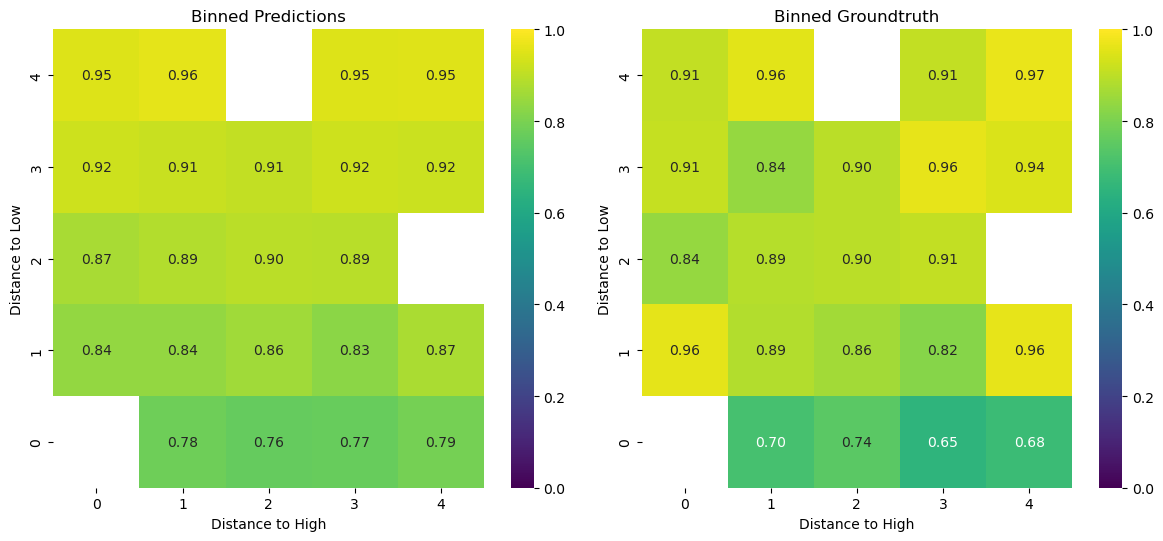

In [112]:
import seaborn as sns

figs, axs = plt.subplots(1,2, figsize=(12, 6))

# plot binned predictions and groundtruth
# tranpose arrays for plotting (distance to High on x-axis)
sns.heatmap(binned_predictions, vmin=0, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True, ax=axs[0])
axs[0].set_xlabel('Distance to High')
axs[0].set_ylabel('Distance to Low')
axs[0].set_title('Binned Predictions')
axs[0].invert_yaxis()

sns.heatmap(binned_groundtruth, vmin=0, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True, ax=axs[1])
axs[1].set_xlabel('Distance to High')
axs[1].set_ylabel('Distance to Low')
axs[1].set_title('Binned Groundtruth')
axs[1].invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()